Student name: Ben Atkin

Student pace: Full time

Scheduled project review date/time: --

Instructor name: Abhineet Kulkarni

Blog post URL: None

# What type of films are currently doing the best at the box office?

My employer sees all the big companies creating original video content, and they want to get in on the fun. They have decided to create a new movie studio, but the problem is they don’t know anything about creating movies. They have hired me to help them better understand the movie industry. My team is charged with doing data analysis and creating a presentation that explores what type of films are currently doing the best at the box office. I must then translate those findings into actionable insights that the CEO can use when deciding what type of films they should be creating.

# Notebook setup:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pandasql import sqldf
import pandas as pd
import re
import seaborn as sns

In [2]:
# Define some helpful functions

def get_dataframes(regex='.*'):
    """Find all dataframes in global namespace
    
    Excludes stored Jupyter output
    Returns dict with df_name: df
    """
    dataframe_dict = {}
    for k in globals().keys():
        if (isinstance(eval(k), pd.core.frame.DataFrame) 
            and not k.startswith('_') 
            and re.search(regex, k)):
            dataframe_dict[k] = eval(k)
    return dataframe_dict

def print_df_stats(df_dict):
    """Print .info(), .head(), .describe() for dataframes

    use get_dataframes() to get df_dict
    """
    for name, df in df_dict.items():
        print('=' * 100)
        print(name)
        print(df.info(), '\n')
        print(df.head(), '\n')
        print(df.describe(include='all'), '\n\n')
        
pysqldf = lambda x: sqldf(x, globals())

In [3]:
# Read in only necessary csv files explicitly
bom_movie_gross_df = pd.read_csv('./unzipped_data/bom.movie_gross.csv')
imdb_name_basics_df = pd.read_csv('./unzipped_data/imdb.name.basics.csv')
# imdb_title_akas_df = pd.read_csv('./unzipped_data/imdb.title.akas.csv')
imdb_title_basics_df = pd.read_csv('./unzipped_data/imdb.title.basics.csv')
# imdb_title_crew_df = pd.read_csv('./unzipped_data/imdb.title.crew.csv')
imdb_title_principals_df = pd.read_csv('./unzipped_data/imdb.title.principals.csv')
# imdb_title_ratings_df = pd.read_csv('./unzipped_data/imdb.title.ratings.csv')
# tmdb_movies_df = pd.read_csv('./unzipped_data/tmdb.movies.csv')
tn_movie_budgets_df = pd.read_csv('./unzipped_data/tn.movie_budgets.csv')

# Initial exploration:

In [4]:
print_df_stats(get_dataframes('.*'))

bom_movie_gross_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
title             3387 non-null object
studio            3382 non-null object
domestic_gross    3359 non-null float64
foreign_gross     2037 non-null object
year              3387 non-null int64
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB
None 

                                         title studio  domestic_gross  \
0                                  Toy Story 3     BV     415000000.0   
1                   Alice in Wonderland (2010)     BV     334200000.0   
2  Harry Potter and the Deathly Hallows Part 1     WB     296000000.0   
3                                    Inception     WB     292600000.0   
4                          Shrek Forever After   P/DW     238700000.0   

  foreign_gross  year  
0     652000000  2010  
1     691300000  2010  
2     664300000  2010  
3     535700000  2010  
4     513900000  2010   

            title studio

           tconst      ordering     nconst category       job   characters
count     1028186  1.028186e+06    1028186  1028186    177684       393360
unique     143454           NaN     604546       12      2965       174762
top     tt2034742           NaN  nm1930572    actor  producer  ["Himself"]
freq           10           NaN        378   256718    108168        43584
mean          NaN  4.739847e+00        NaN      NaN       NaN          NaN
std           NaN  2.747446e+00        NaN      NaN       NaN          NaN
min           NaN  1.000000e+00        NaN      NaN       NaN          NaN
25%           NaN  2.000000e+00        NaN      NaN       NaN          NaN
50%           NaN  4.000000e+00        NaN      NaN       NaN          NaN
75%           NaN  7.000000e+00        NaN      NaN       NaN          NaN
max           NaN  1.000000e+01        NaN      NaN       NaN          NaN 


tn_movie_budgets_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Dat

tn_movie_budgets and bom_movie_gross are the only datasets provided that have any revenue numbers yet those datasets don't have foreign keys to imdb data. I want to see if there's a correlation between some imdb features (runtime_in_minutes, rating, genre) and the revenue numbers, so I'll have to join tables. Since there is no integer-type foreign key between the datasets I'll have to join tables on a string-type column that contains the movie name. 

In [5]:
join_query = '''
select 
    title,
    studio,
    year,
    tconst,
    primary_title,
    original_title,
    start_year,
    runtime_minutes,
    genres,
    id,
    release_date,
    movie,
    production_budget,
    tn_movie_budgets_df.domestic_gross,
    worldwide_gross
from bom_movie_gross_df 
join imdb_title_basics_df
    on original_title = title
join tn_movie_budgets_df
    on movie = title;
'''

joined = pysqldf(join_query)

In my opinion, joining tables like this is poor practice because movies that have the same title but are actually different movies will end up with duplicated data from the joined table. I'll have to arbitrarily drop all but one of the duplicate rows with no guarantee that I dropped the correct row. A great example of this issue is Adam Green's movie "Frozen" (2010) and the Disney movie "Frozen" (2013) having duplicate financial data from the bom_movie_gross table. However, because this is a school project with pre-provided data and the scope of the project doesn't include sourcing better data, I'll proceed with my analysis as if the data were reliable.

In [6]:
# Exploring the new table
print_df_stats(get_dataframes('.*joined.*'))

joined
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1531 entries, 0 to 1530
Data columns (total 15 columns):
title                1531 non-null object
studio               1531 non-null object
year                 1531 non-null int64
tconst               1531 non-null object
primary_title        1531 non-null object
original_title       1531 non-null object
start_year           1531 non-null int64
runtime_minutes      1431 non-null float64
genres               1508 non-null object
id                   1531 non-null int64
release_date         1531 non-null object
movie                1531 non-null object
production_budget    1531 non-null object
domestic_gross       1531 non-null object
worldwide_gross      1531 non-null object
dtypes: float64(1), int64(3), object(11)
memory usage: 179.5+ KB
None 

                        title studio  year     tconst  \
0                 Toy Story 3     BV  2010  tt0435761   
1                   Inception     WB  2010  tt1375666   
2         Shrek

There are 1531 movies that were successfully joined on the text columns; bom_movie_gross.title, imdb_title_basics.original_title, and tn_movie_budgets.movie. Though I would prefer to be provided with a more reliable joined dataset we'll use these ~1500 as our sample.

# Data cleaning and processing

In [7]:
# Drop movies that don't have a genre, domestic_gross or runtime_minutes
joined.dropna(subset=['genres', 'runtime_minutes'], inplace=True)

In [8]:
# Cleaning production_budget, domestic_gross and worldwide_gross columns
joined.production_budget = joined.production_budget.map(lambda x: re.sub('[$,]', '', x))
joined.worldwide_gross = joined.worldwide_gross.map(lambda x: re.sub('[$,]', '', x))
joined.domestic_gross = joined.domestic_gross.map(lambda x: re.sub('[$,]', '', x))

In [9]:
# Convert production_budget, domestic_gross, worldwide_gross to int64
joined.production_budget = joined.production_budget.astype('int64')
joined.domestic_gross = joined.domestic_gross.astype('int64')
joined.worldwide_gross = joined.worldwide_gross.astype('int64')

In [10]:
# Convert release_date to datetime
joined.release_date = pd.to_datetime(joined.release_date)

In [11]:
# Adding new column to calculate profit, profit percentage
joined['total_profit'] = joined.worldwide_gross - joined.production_budget
joined['gross_margin'] = joined.total_profit / joined.worldwide_gross

In [12]:
# Adding new column to indicate if movie was profitable or not
joined['profitable'] = joined.gross_margin > 0

In [13]:
# Adding new column to imdb_name_basics
imdb_name_basics_df.known_for_titles.fillna(value='', inplace=True)
imdb_name_basics_df['movie_count'] = imdb_name_basics_df.known_for_titles.map(lambda x: len(x.split(',')))

In [14]:
# There are some nan value in our movie_count column
imdb_name_basics_df.movie_count.fillna(0, inplace=True)

In [15]:
# Some worldwide_gross numbers are 0 so profit / worldwide_gross is div zero == -inf
joined.loc[joined.gross_margin == joined.gross_margin.min()]

,title,studio,year,tconst,primary_title,original_title,start_year,runtime_minutes,genres,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,total_profit,gross_margin,profitable
655,Snitch,LG/S,2013,tt0882977,Snitch,Snitch,2013,112.0,"Action,Drama,Thriller",52,2012-12-31,Snitch,850000,0,0,-850000,-inf,False
670,Trance,FoxS,2013,tt1111235,Trance,Trance,2010,83.0,Horror,31,2012-12-31,Trance,950000,0,0,-950000,-inf,False
672,Trance,FoxS,2013,tt1924429,Trance,Trance,2013,101.0,"Crime,Drama,Mystery",31,2012-12-31,Trance,950000,0,0,-950000,-inf,False
1084,Eden,BG,2015,tt1734433,Eden,Eden,2012,98.0,"Crime,Drama",66,2016-01-19,Eden,2300000,0,0,-2300000,-inf,False
1085,Eden,BG,2015,tt2063641,Eden,Eden,2012,101.0,"Comedy,Drama",66,2016-01-19,Eden,2300000,0,0,-2300000,-inf,False
1086,Eden,BG,2015,tt2132321,Eden,Eden,2016,71.0,Drama,66,2016-01-19,Eden,2300000,0,0,-2300000,-inf,False
1087,Eden,BG,2015,tt3032282,Eden,Eden,2014,90.0,"Drama,Thriller",66,2016-01-19,Eden,2300000,0,0,-2300000,-inf,False
1088,Eden,BG,2015,tt3090634,Eden,Eden,2014,131.0,"Biography,Drama,Music",66,2016-01-19,Eden,2300000,0,0,-2300000,-inf,False
1089,Eden,BG,2015,tt5975878,Eden,Eden,2015,90.0,Animation,66,2016-01-19,Eden,2300000,0,0,-2300000,-inf,False
1090,Eden,BG,2015,tt7539088,Eden,Eden,2019,85.0,"Crime,Drama",66,2016-01-19,Eden,2300000,0,0,-2300000,-inf,False


In [23]:
# Drop the 2 rows with 0 in worldwide gross
joined.drop(joined.loc[joined.worldwide_gross == 0].index, axis=0, inplace=True)

In [24]:
# Drop duplicate rows based on title
joined.drop_duplicates(subset=['title'], inplace=True)

After cleaning columns we end up with 1143 unique movies between 2010 and 2018 to analyze.

In [25]:
print_df_stats(get_dataframes('.*joined.*'))

joined
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1142 entries, 0 to 1530
Data columns (total 18 columns):
title                1142 non-null object
studio               1142 non-null object
year                 1142 non-null int64
tconst               1142 non-null object
primary_title        1142 non-null object
original_title       1142 non-null object
start_year           1142 non-null int64
runtime_minutes      1142 non-null float64
genres               1142 non-null object
id                   1142 non-null int64
release_date         1142 non-null datetime64[ns]
movie                1142 non-null object
production_budget    1142 non-null int64
domestic_gross       1142 non-null int64
worldwide_gross      1142 non-null int64
total_profit         1142 non-null int64
gross_margin         1142 non-null float64
profitable           1142 non-null bool
dtypes: bool(1), datetime64[ns](1), float64(2), int64(7), object(7)
memory usage: 161.7+ KB
None 

                        title 

# How many films are actually profitable?

The gross_margin field has a range of (-inf to 1) and is very sensitive to extremely low values so I'm going to limit the visualization to movies that lost \\$3 for every \\$1 they made in revenue. There are only 62  observations (~5%) that are filtered out.

In [26]:
# Creating new df to show limited scope of gross_margin variable
margin_limit_df = joined.loc[joined.gross_margin > -3]

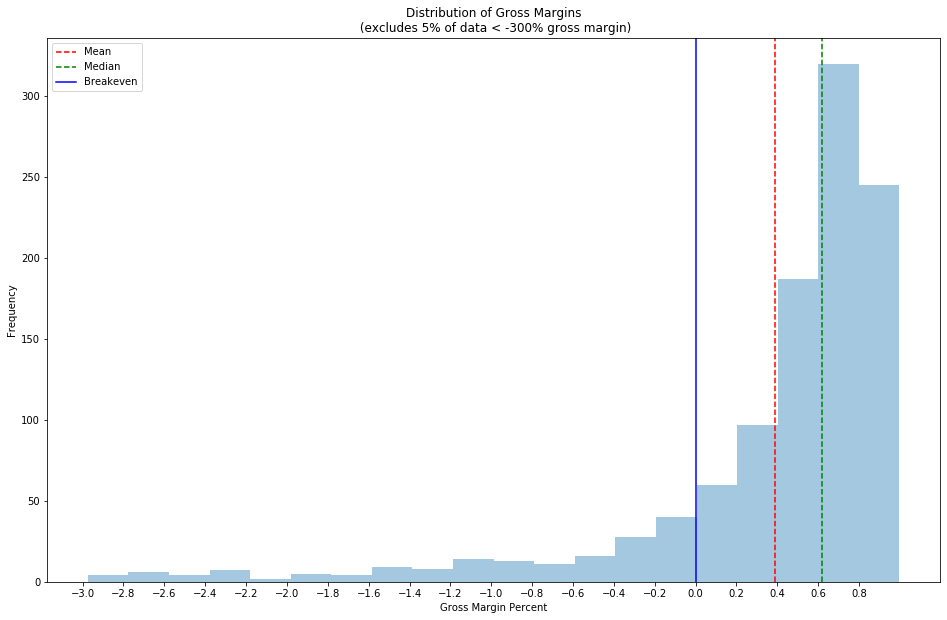

In [27]:
# Plot frequency of gross_margins
fig1, ax1 = plt.subplots(figsize=(16, 10))
plt.title('Distribution of Gross Margins\n (excludes 5% of data < -300% gross margin)')
plt.ylabel('Frequency')
plt.xlabel('Gross Margin Percent')
plt.xticks(np.arange(-3, 1, .2))
mean=margin_limit_df.gross_margin.mean()
median=margin_limit_df.gross_margin.median()
ax1.axvline(mean, color='r', linestyle='--')
ax1.axvline(median, color='g', linestyle='--')
ax1.axvline(0, color='b', linestyle='-')
plt.legend({'Mean':mean,'Median':median, 'Breakeven':0})
sns.distplot(margin_limit_df.gross_margin, bins=20, kde=False, ax=ax1, axlabel='Gross Margin Percent');

# Which directors have the most profitable films?

In [28]:
join_query = '''
with directors as (
    select 
        tconst, 
        movie_count, 
        group_concat(primary_name, '/') as director_names
    from imdb_title_principals_df
        join imdb_name_basics_df using (nconst)
    where category = 'director'
    group by tconst)
select
    joined.*,
    director_names,
    movie_count
from joined
left join directors using ('tconst')
'''

director_joined = pysqldf(join_query)

Now that we have the director_joined dataframe we can see which director had the most profitable films.

In [29]:
total_profit_by_director = director_joined.groupby('director_names')['total_profit'].mean()
gross_margin_by_director = director_joined.groupby('director_names')['gross_margin'].mean()

In [30]:
top_10_gross_margin = gross_margin_by_director.sort_values(ascending=False).head(10)
top_10_gross_margin

director_names
Travis Cluff/Chris Lofing     0.997599
William Brent Bell            0.990173
Levan Gabriadze               0.984463
Tod Williams                  0.983100
Jamie Buckner                 0.982077
Jordan Peele                  0.980420
Bradley Parker                0.976422
Henry Joost/Ariel Schulman    0.970420
Nitesh Tiwari                 0.967759
Robert Heath                  0.963207
Name: gross_margin, dtype: float64

In [31]:
top_10_total_profit = total_profit_by_director.sort_values(ascending=False).head(10)
top_10_total_profit

director_names
Kyle Balda                               1.086336e+09
Joss Whedon                              1.072414e+09
Anthony Russo/Joe Russo                  1.060869e+09
Kyle Balda/Pierre Coffin/Eric Guillon    9.597278e+08
Byron Howard/Rich Moore/Jared Bush       8.694296e+08
Lee Unkrich                              8.688795e+08
Andrew Stanton/Angus MacLane             8.212152e+08
Yarrow Cheney/Chris Renaud               8.117505e+08
Steve Martino/Mike Thurmeier             7.847651e+08
Sam Mendes                               7.450740e+08
Name: total_profit, dtype: float64

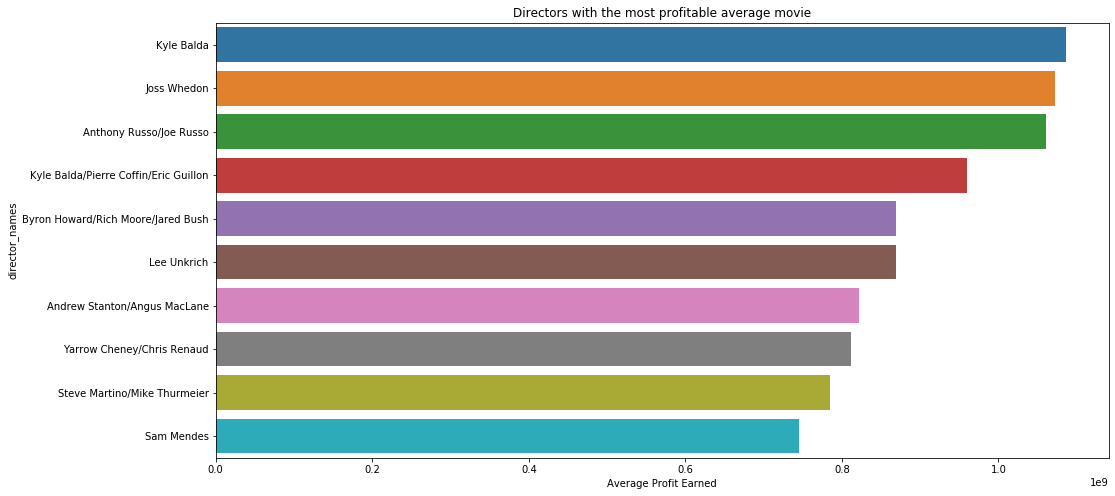

In [32]:
fig2, ax2 = plt.subplots(figsize=(16, 8))
plt.title('Directors with the most profitable average movie')
plt.ylabel('Directors')
plt.xlabel('Average Profit Earned')
ax2.set(ylabel='Directors')
sns.barplot(top_10_total_profit.values, top_10_total_profit.index);

# When is the best time of year to release a movie?

To answer this question I will need to:

Pick a sufficiently large subset of my data that is most recent and won't be affected by inflation, or other time-sensitive variables.

I will use the gross_margin variable instead of the total_profit variable because gross_margin is a relative statistic comparing expense to revenue and will not be affected by inflation as much as the total_profit variable will be.

I'll then group the data by month and plot observations on a bar plot/line plot using the gross_margin mean or median OR use scatter plot.

In [128]:
# How many movies per year are in my sample?
joined.groupby(joined.release_date.map(lambda x: x.strftime('%Y'))).title.count()

release_date
1984      1
1986      1
2001      1
2003      2
2005      1
2010    140
2011    155
2012    137
2013    125
2014    123
2015    136
2016    133
2017     96
2018     92
Name: title, dtype: int64

In [129]:
# Create new df with only the last 5 years of observations
last_5 = joined.loc[joined.release_date.map(lambda x: int(x.strftime('%Y'))) >= 2014]

In [130]:
# Create new column called release_month
last_5['release_month'] = last_5.release_date.map(lambda x: x.strftime('%b'))

/home/ben/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


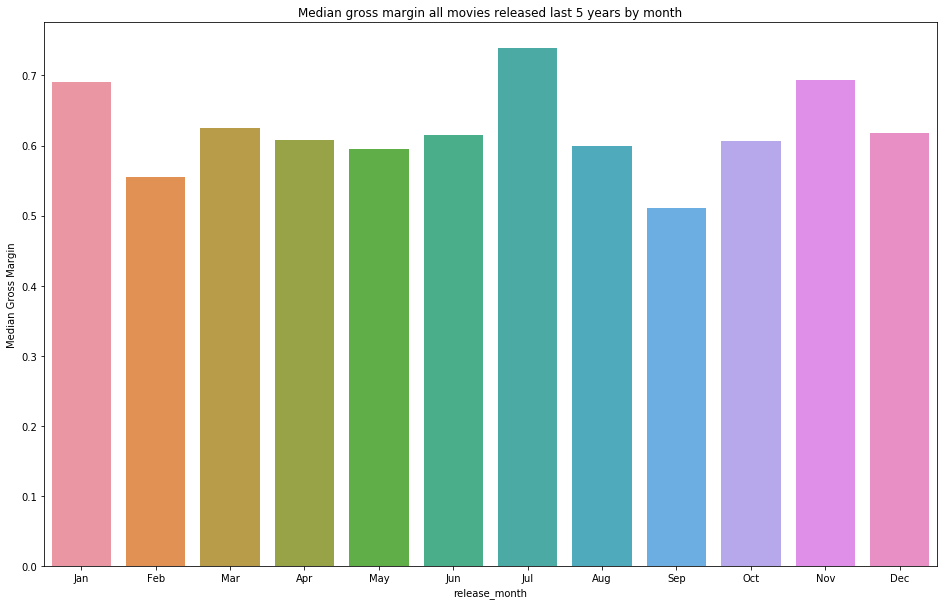

In [131]:
# Group by month and plot
last_5_grouped = last_5.groupby('release_month')
fig3, ax3 = plt.subplots(figsize=(16, 10))
plt.title('Median gross margin all movies released last 5 years by month')
plt.ylabel('Median Gross Margin')
plt.xlabel('Gross Margin Percent')
order = ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec')
sns.barplot(last_5_grouped.gross_margin.median().index, 
            last_5_grouped.gross_margin.median().values, 
            order=order);

According to the graph the best time to release a movie with regard to gross margin would be in the months of July, January, or November. One caveat: the difference between high gross margin months and low is so miniscule that release_month may not be a statistically significant variable. Other variables like, the quality of the film, the popularity of the cast and directors will probably affect the gross margins much more.

# For how many films are the directors "known for"? Could this be used as a predictor of a director's popularity?

The imdb data has an interesting column called "known_for_titles" which is a list of the directors' most popular films that they are associated with. I'm interested to see what the frequency distribution of the count of those films is. Are there directors who are known for many more films than their counterparts? Perhaps those directors with higher counts of known_for_titles are most popular and their reputation will help the films success.

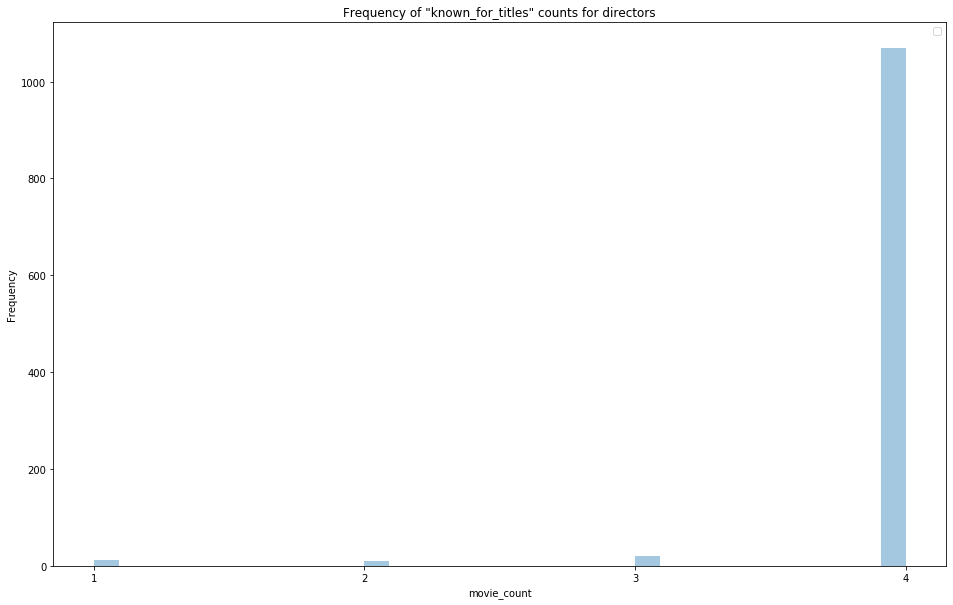

In [100]:
fig4, ax4 = plt.subplots(figsize=(16, 10))
plt.title('Frequency of "known_for_titles" counts for directors')
plt.ylabel('Frequency')
plt.xlabel('Number of titles direcor is know for')
plt.xticks(np.arange(0, 5, 1))
plt.legend({'Mean':mean,'Median':median, 'Breakeven':0})
sns.distplot(director_joined.sort_values(by='movie_count', ascending=False).movie_count, kde=False);

The vast majority of directors only have 4 titles listed in the known_for_titles column which seems to indicate that the originators of the data truncated the number of titles in that column to 4 and therefore using the known_for_titles column as an indication of popularity of the director isn't possible.